# Examine tuning patterns of model hidden units

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from spatialnet.trajectory import TrajectoryGenerator
from spatialnet.fileio import load_run, load_params, load_checkpoint
from spatialnet.parameters import print_params
from spatialnet.metrics import compute_ratemaps
from spatialnet.visualize import plot_ratemaps, plot_activity

## Load model

In [2]:
# Directory where model is loaded from
RUN_DIRNAME = '20220524_01'
RUN_DIRPATH = f'../models/{RUN_DIRNAME}'

# Load model and parameters
run_params, model = load_run(RUN_DIRPATH)
print_params(run_params)

model:
  n_units: 100
  output_bias: false
  rnn_bias: true
num_batches: 1000
num_epochs: 8
test_batch_size: 500
trainer:
  batch_size: 500
  lambda_h: 10.0
  lambda_w: 10.0
  learning_rate: 0.0001
trajectory:
  boundary_height: 2.0
  boundary_shape: square
  coordinates: cartesian
  mean_speed: 0.2
  n_steps: 450
  rng_seed: 999
  std_norm: 0.5
  time_step: 0.1



## Run model on simulated trajectories and compute ratemaps

In [3]:
# Parameters
N_TRIALS = 500
RNG_SEED = 1665

# Use trajectory generator with different random seed than test data
tparams = dict(run_params['trajectory'], rng_seed=RNG_SEED)
tgen = TrajectoryGenerator(**tparams)

# Sample batch
vel, pos = tgen.smp_batch(N_TRIALS)

# Compute ratemaps
activations, h = compute_ratemaps(model, vel, pos)

## Plot ratemaps

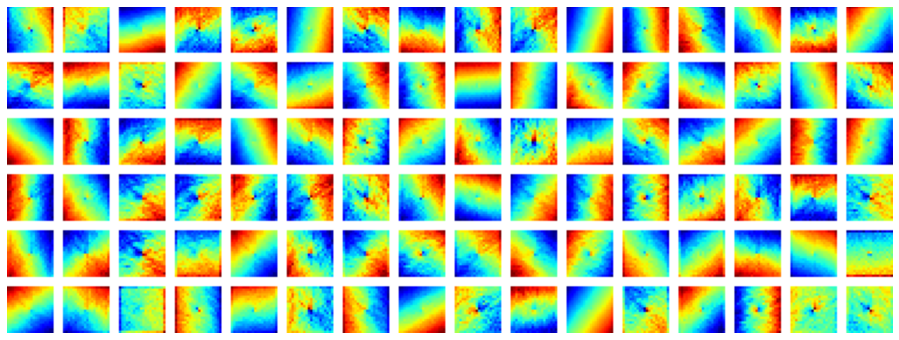

In [4]:
# Plot all cells
n_plot = model.n_units

# Figure size
plt.figure(figsize=(16, 4 * n_plot // 8**2))

# Ratemap plot
rm_fig = plot_ratemaps(activations, n_plot)
plt.imshow(rm_fig)
plt.axis('off')

plt.savefig(f'{RUN_DIRNAME}_tuning.png')

## Plot activity

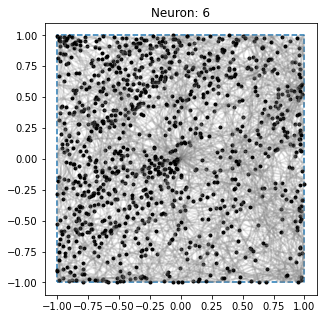

In [5]:
n_trials_plt = 100
th = 0.2
neuron = 6

# Activity of selected hidden neuron
h_neuron = h[:, :, neuron]

fig, ax = plt.subplots(1, figsize=(5, 5))
ax.set_title(f'Neuron: {neuron}')
plot_activity(tgen.boundary, pos, h_neuron, threshold=th, n_trials=n_trials_plt, ax=ax)

plt.savefig(f'{RUN_DIRNAME}_activity_{neuron}.png')


## Activity histogram

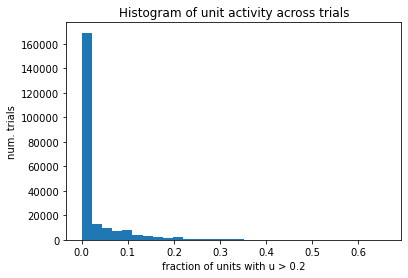

In [6]:
# Threshold above which cell is considered "active"
th = 0.2

# Compute fraction of cells at each time point that are active
h_all = np.reshape(h, (-1, model.n_units))
pct_active = np.count_nonzero(np.abs(h_all) > th, axis=1) / 100

# Plot histogram of activity rates
plt.hist(pct_active, bins=30);
plt.title('Histogram of unit activity across trials')
plt.xlabel(f'fraction of units with u > {th}')
plt.ylabel('num. trials')

plt.savefig(f'{RUN_DIRNAME}_hist_activity.png')